In [2]:
import numpy as np
# import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
measures = dict();
measures['recall'] = 0;
measures['precision'] = 1;
measures['confidence'] = 2;
measures['mutual_information'] = 3;
measures['jaccard'] = 4;
measures['f_measure'] = 5;
measures['odds_ratio'] = 6;
measures['specificity'] = 7;
measures['negative_reliability'] = 8;
measures['sebag_schoenauer'] = 9;
measures['accuracy'] = 10;
measures['support'] = 11;
measures['confidence_causal'] = 12;
measures['lift'] = 13;
measures['ganascia'] = 14;
measures['kulczynsky_1'] = 15;
measures['coverage'] = 16;
measures['prevalence'] = 17;
measures['relative_risk'] = 18;
measures['piatetsky_shapiro'] = 19;
measures['novelty'] = 20;
measures['yules_q'] = 21;
measures['yules_y'] = 22;
measures['cosine'] = 23;
measures['least_contradiction'] = 24;
measures['odd_multiplier'] = 25;
measures['confirm_descriptive'] = 26;
measures['confirm_causal'] = 27;
measures['certainty_factor'] = 28;
measures['loevinger'] = 29;
measures['conviction'] = 30;
measures['information_gain'] = 31;
measures['laplace_correction'] = 32;
measures['klosgen'] = 33;
measures['zhang'] = 34;
measures['normalized_mutual_information'] = 35;
measures['one_way_support'] = 36;
measures['two_way_support'] = 37;
measures['implication_index'] = 38

In [15]:
class contingency_table(object):
    def __init__(self, table = np.array([]), n_measures = 0):
        if np.min(table) < 0:
            raise ValueError('frequency of the matrix cannot be negative');
        self.table = table;
        self.scores = np.zeros(n_measures);
        self.compute_probabilities();
    
    def compute_probabilities(self):
        self.f11 = self.table[0];
        self.f10 = self.table[1];
        self.f01 = self.table[2];
        self.f00 = self.table[3];
        self.N = sum(self.table);
        
        self.P_a = (self.f11 + self.f10)/self.N;
        self.P_b = (self.f11 + self.f01)/self.N;
        self.P_aprime = 1 - self.P_a;
        self.P_bprime = 1 - self.P_b;

        
        self.P_ab = self.f11/self.N;
        self.P_abprime = self.f10/self.N;
        self.P_aprimeb = self.f01/self.N;
        self.P_aprimebprime = self.f00/self.N;

        self.P_agivenb = self.P_ab / self.P_b;
        self.P_bgivena = self.P_ab / self.P_a;
        self.P_bgivenaprime = self.P_aprimeb / self.P_aprime;
    
    def compute_scores(self):
        self.compute_probabilities();
        self.scores[0] = self.recall();
        self.scores[1] = self.precision();
        self.scores[2] = self.confidence();
        self.scores[3] = self.mutual_information();
        self.scores[4] = self.jaccard();
        self.scores[5] = self.f_measure();
        self.scores[6] = self.odds_ratio();
        self.scores[7] = self.specificity();
        self.scores[8] = self.negative_reliability();
        self.scores[9] = self.sebag_schoenauer();
        self.scores[10] = self.accuracy();
        self.scores[11] = self.support();
        self.scores[12] = self.confidence_causal();
        self.scores[13] = self.lift();
        self.scores[14] = self.ganascia();
        self.scores[15] = self.kulczynsky_1();
        self.scores[16] = self.coverage();
        self.scores[17] = self.prevalence();
        self.scores[18] = self.relative_risk();
        self.scores[19] = self.piatetsky_shapiro();
        self.scores[20] = self.novelty();
        self.scores[21] = self.yules_q();
        self.scores[22] = self.yules_y();
        self.scores[23] = self.cosine();
        self.scores[24] = self.least_contradiction();
        self.scores[25] = self.odd_multiplier();
        self.scores[26] = self.confirm_descriptive();
        self.scores[27] = self.confirm_causal();
        self.scores[28] = self.certainty_factor();
        self.scores[29] = self.loevinger();
        self.scores[30] = self.conviction();
        self.scores[31] = self.information_gain();
        self.scores[32] = self.laplace_correction();
        self.scores[33] = self.klosgen();
        self.scores[34] = self.zhang();
        self.scores[35] = self.normalized_mutual_information();
        self.scores[36] = self.one_way_support();
        self.scores[37] = self.two_way_support();
        self.scores[38] = self.implication_index();
    
    def recall (self):
        if (self.f11 + self.f01) == 0:
            return np.nan
        else:
            return self.f11 / (self.f11 + self.f01);

    def precision (self):
        if (self.f11 + self.f10) == 0:
            return np.nan;
        else:
            return self.f11/(self.f11 + self.f10);
    
    def confidence (self):
        return self.precision();
    
    def mutual_information(self):
        if self.f11 != 0 and self.f00 != 0 and self.f01 != 0 and self.f10 != 0:
            MI = self.P_ab * np.log2(self.P_ab/(self.P_a * self.P_b))
            + self.P_abprime * np.log2(self.P_abprime/(self.P_a * self.P_bprime))
            + self.P_aprimeb * np.log2(self.P_aprimeb/(self.P_aprime * self.P_b))
            + self.P_aprimebprime * np.log2(self.P_aprimebprime/(self.P_aprime * self.P_bprime));        
            return MI/self.N;
        else:
            return np.nan;

    def jaccard (self):
        if (self.f11 + self.f10 + self.f01) == 0:
            return np.nan;
        else:
            J = self.f11 / (self.f11 + self.f10 + self.f01);
            return J;

    def f_measure (self):
        if self.P_agivenb + self.P_bgivena == 0:
            return np.nan;
        else:
            FM = (2 * self.P_agivenb * self.P_bgivena) / (self.P_agivenb + self.P_bgivena);
            return FM;
    
    def odds_ratio(self):
        OR = (self.f11 * self.f00)/(self.f01 * self.f10);
        return OR;

    def specificity(self):
        den = self.f00 + self.f01;
        if den != 0:
            return self.f00/den;
        else:
            return np.nan;
    
    def negative_reliability(self):
        return self.specificity();

    def sebag_schoenauer(self):
        if self.f10:
            return self.f11/self.f10;
        else:
            return np.nan;
        
    def accuracy(self):
        if self.N:
            return (self.f11 + self.f00)/self.N;
        else:
            return np.nan;

    def support(self):
        return self.f11/self.N;

    def confidence_causal(self):
        CC = (self.f11 / (self.f11 + self.f10)) + (self.f00 / (self.f00 + self.f10));
        return CC/2;

    def lift(self):
        return (self.f11 * self.N)/((self.f11 + self.f10) * (self.f11 + self.f01));

    def ganascia(self):
        G = 2 * self.P_bgivena - 1;
        return G;

    def kulczynsky_1 (self):
        K = self.f11 / (self.f10 + self.f01);
        return K;

    def coverage(self):
        return self.P_a;

    def prevalence(self):
        return self.P_b;

    def relative_risk(self):
        RR = self.P_bgivena / self.P_bgivenaprime;
        return RR;

    def piatetsky_shapiro(self):
        return self.P_ab - self.P_a * self.P_b;

    def novelty(self):
        return self.piatetsky_shapiro();

    def yules_q(self):
        YQ = (self.f11 * self.f00 - self.f10 * self.f01) / (self.f11 * self.f00 + self.f10 * self.f01);
        return YQ;

    def yules_y(self):
        YY = (np.sqrt(self.f11 * self.f00) - np.sqrt(self.f10 * self.f01)) / (np.sqrt(self.f11 * self.f00) + np.sqrt(self.f10 * self.f01));
        return YY;

    def cosine(self):
        cosine = self.P_ab / np.sqrt(self.P_a * self.P_b);
        return cosine;

    def least_contradiction(self):
        LC = (self.f11 - self.f10) / (self.f11 + self.f01);
        return LC;

    def odd_multiplier(self):
        OM = (self.P_ab * self.P_bprime) / (self.P_b * self.P_abprime);
        return OM;

    def confirm_descriptive(self):
        CD = self.P_ab - self.P_abprime;
        return CD;

    def confirm_causal(self):
        CC = self.P_ab + self.P_aprimebprime - 2 * self.P_abprime;
        return CC;

    def certainty_factor(self):
        CF = 1 - self.P_abprime / (self.P_a * self.P_bprime)
        return CF;
    
    def loevinger(self):
        return self.certainty_factor();

    def conviction(self):
        conviction = (self.P_a * self.P_bprime) / self.P_abprime;
        return conviction;

    def information_gain(self):
        IG = np.log2(self.P_ab / (self.P_a * self.P_b));
        return IG;

    def laplace_correction(self):
        k = 2;
        LC = (self.f11 + 1) / (self.f11 + self.f10 + k);
        return LC;

    def klosgen(self):
        KL = np.sqrt(self.P_a) * (self.P_bgivena - self.P_b);
        return KL;

    def zhang(self):
        den_1 = self.P_ab * (1 - self.P_b);
        den_2 = self.P_b * (self.P_a - self.P_ab);
        if den_1 > den_2:
            ZH = (self.P_ab - self.P_a * self.P_b)/den_1;
        else:
            ZH = (self.P_ab - self.P_a * self.P_b)/den_2;
        return ZH;

    def normalized_mutual_information(self):
        MI = self.mutual_information();
        NMI = MI / (-self.P_a * np.log2(self.P_a) - self.P_aprime * np.log2(self.P_aprime));
        return NMI;

    def one_way_support(self):
        OWS = self.P_bgivena * np.log2(self.P_bgivena / self.P_b);
        return OWS

    def two_way_support(self):
        TWS = self.P_ab * np.log2(self.P_bgivena / self.P_b);
        return TWS;

    def implication_index(self):
        prod = self.P_a * self.P_bprime; 
        IIN = np.sqrt(self.N) * (self.P_abprime - prod) / np.sqrt(prod);
        return IIN;

In [40]:
class ranks(object):
    def __init__ (self, scores_matrix):
        self.scores = scores_matrix;
        self.ranks = np.zeros(shape=scores_matrix.shape);
        self.compute_ranks();
    
    def compute_ranks(self):
        for idx,score in enumerate(self.scores.T):
            self.ranks[:,idx] = self.return_ranks(score);
    
    def return_ranks(self, scores_array):
        # takes mxn
        temp = np.argsort(scores_array)[::-1];

        ranks_array = np.empty(len(scores_array), float);
        #   Assigning ranks to the scores according to the order in 'temp' array (descending score)
        ranks_array[temp] = np.arange(len(scores_array));
        #   Assigning nan ranks to nan scores
        ranks_array[np.isnan(scores_array)] = np.nan;

        unique, counts = np.unique(scores_array[~np.isnan(scores_array)], return_counts=True);

        # Handle ties by assigning averaged values to the tied scores
        for idx,u in enumerate(unique):
            ranks_array[scores_array==u] = ranks_array[scores_array==u].sum()/counts[idx];
        return ranks_array;
    
    def visualize(self):
        self.compute_correlation();
        self.show_correlation_matrix();
        self.show_dendrogram();
    
    def compute_correlation(self):
        self.dist_spearman = spearmanr(self.ranks).correlation;
        
    def compute_dissimilarity(self):
        if not hasattr (self, 'dist_spearman'):
            self.compute_correlation();
        self.dissimilarity = (1 - self.dist_spearman) / 2;
        self.dissimilarity_1D = squareform(self.dissimilarity, checks=False);
        self.dissimilarity_uppertriangle = squareform(self.dissimilarity_1D);

    def compute_clusters(self):
        if not hasattr (self, 'dissimilarity_uppertriangle'):
            self.compute_dissimilarity();
        self.cluster = hierarchy.linkage(self.dissimilarity_uppertriangle, method='complete');
        
    def form_clusters(self, n_clusters):
        if not hasattr(self, 'cluster'):
            self.compute_clusters();
        clusters = hierarchy.cut_tree(self.cluster, n_clusters=n_clusters);
        for n in range(n_clusters):
            print(n,np.count_nonzero((clusters==n)), (clusters==n).nonzero()[0]);
        
    def show_correlation_matrix(self):
        if not hasattr (self, 'dist_spearman'):
            self.compute_correlation();
        plt.figure(figsize=(10,10));
        sns.heatmap(self.dist_spearman, vmin=-1, vmax=1, cmap='YlGnBu');
        plt.show();

    def show_dendrogram(self):
        if not hasattr(self, 'cluster'):
            self.compute_clusters();
        plt.figure(figsize=(10,10));
        hierarchy.dendrogram(self.cluster, orientation='right', color_threshold=1);
        plt.show();
        
    def remove_outliers(self, indices):
        self.ranks = np.delete(arr=self.ranks, obj=indices, axis=1);


In [17]:
def generate_contingency_tables(vals):
    tables = np.zeros(shape=(vals.size**4,4));
    i = 0;
    for tp in vals:
        for tn in vals:
            for fp in vals:
                for fn in vals:
                    tables[i] = [tp,tn,fp,fn];
                    i += 1;
    return tables;

0 15 [ 0  1  2  4  5  9 11 12 14 15 21 22 24 25 30]
1 21 [ 3  6  7  8 10 13 16 17 18 19 20 23 26 27 28 29 31 32 33 34 35]


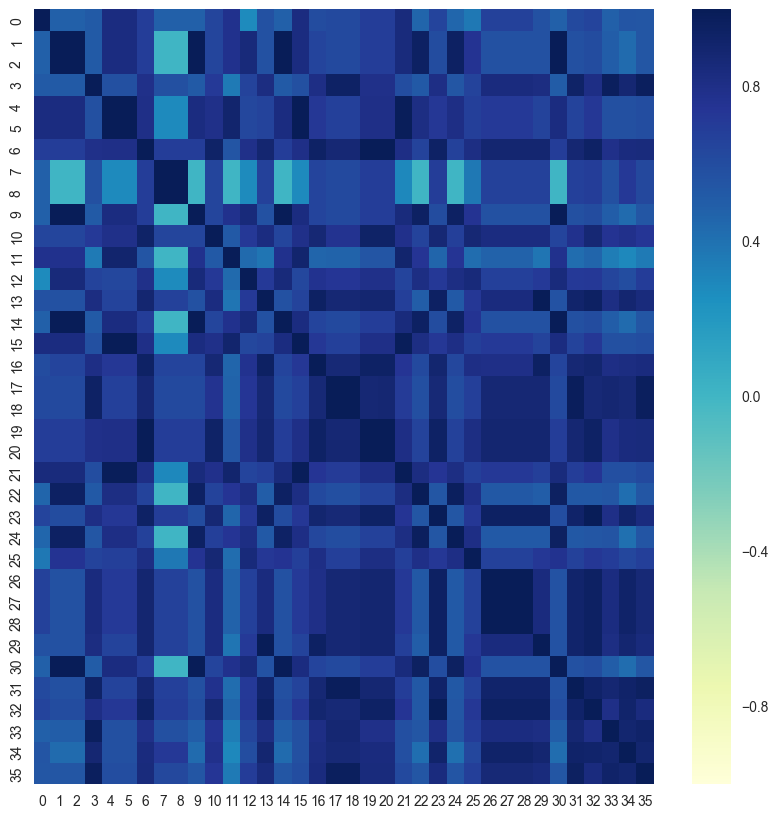

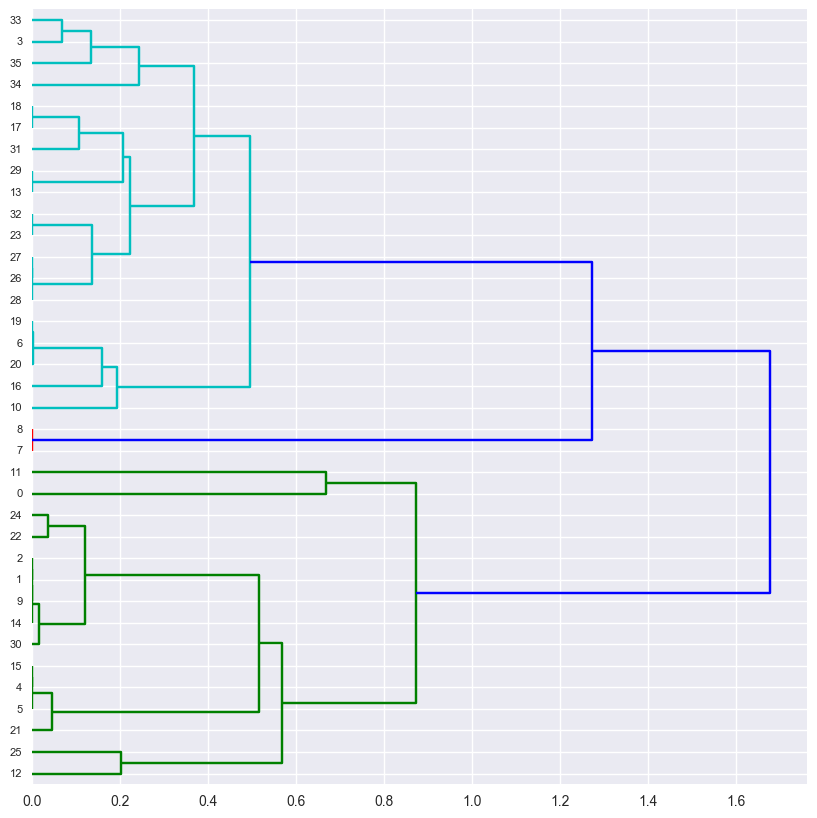

In [50]:
vals = np.array([1,2,11,100,1000,10000]);

#generates contingency tables with all f_ij's taking all possibile values in 'vals' array
tables = generate_contingency_tables(vals);

#number of measures being computed
n_measures = 39;

#initialize the scores matrix
scores_matrix = np.zeros(shape=(1296,n_measures));

# computes scores for each table and updates the scores matrix
for idx,table in enumerate(tables):
    t = contingency_table(table, n_measures);
    t.compute_scores();
    scores_matrix[idx] = t.scores;
    
#computes the ranks class with the given scores
ranks_matrix = ranks(scores_matrix)

ranks_matrix.remove_outliers([measures['implication_index'], measures['coverage'], measures['prevalence']]);

## Clustering
n_clusters = 2

#prints indices of the measures in each cluster
ranks_matrix.form_clusters(n_clusters);

#plots the heatmap for the spearman correlation matrix and dendrogram derived from spearman correlations
ranks_matrix.visualize();
